# HCP Gambling - rfMRI analysis

This analysis aims to show whether the ACT-R models prediction (declarative model vs. RL modle) could also predict resting state brain connectivity

In [1]:
from __future__ import division
from lasso_func import *

import warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

----

### Load ACT-R Model Preidction Data

The dependent variable is the ACTR model prediction M1 or M2


In [2]:
power2011 = pd.read_csv('../bin/power_2011.csv', usecols=["ROI", "X", "Y", "Z", "Network", "Color", "NetworkName"]) 

# convert to 1/0 dummy variable 
model_dat = pd.read_csv('../actr-models/model_output/MODELLogLikelihood.csv')
model_dat['best_model1'] = np.where(model_dat['best_model']== 'm1', 1, 0)

---
### Load Subj Cocountivty Matrix

First, let's compare differnt correlation matrix

- raw: not regress out motion artifacts
- mr: motion regression
- r: peaerson correlation matrix
- pr: partial correlation


In [3]:
subj_wide1 = load_subj('./REST_corr/REST1/', model_dat, corr_fname='raw_pcorr.txt')
subj_wide2 = load_subj('./REST_corr/REST1/', model_dat, corr_fname='mr_pcorr.txt')
subj_wide3 = load_subj('./REST_corr/REST1/', model_dat, corr_fname='raw_corr_pearson.txt')
subj_wide4 = load_subj('./REST_corr/REST1/', model_dat, corr_fname='mr_corr_pearson.txt')

comp = pd.DataFrame()
comp['raw_pr'] = subj_wide1['[1, 2]']
comp['mr_pr'] = subj_wide2['[1, 2]']
comp['raw_r'] = subj_wide3['[1, 2]']
comp['mr_r'] = subj_wide4['[1, 2]']
comp.head()

,raw_pr,mr_pr,raw_r,mr_r
0,0.252328,0.223943,0.740244,0.526020
1,0.402622,0.393709,0.586992,0.902781
2,0.193616,0.193988,0.587789,0.656372
3,0.129045,0.128777,0.684227,0.845326
4,0.209995,0.213416,0.632762,0.633336


Next, convert many connectivity matries into a wide matrix `subj_wide`, with a dimension of `N`(number of subjects) x `M` (264 x 264 = 69696)

In [4]:
subj_wide = load_subj('./REST_corr/REST1/', model_dat)
DV = 'best_model1'  # define dependent variable(behavioral measurements) # DV = 'MLAT5' #MLAT5, alpha2, SymmetrySpan

And now, let’s visualize the histogram of the dependent variable we are trying to predict:

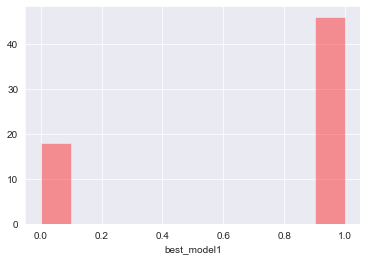

DV distribution:
 1    46
0    18
Name: best_model1, dtype: int64


In [5]:
sns.distplot(subj_wide[DV], kde=False, color='red', bins=10)
plt.show()

print('DV distribution:\n', subj_wide[DV].value_counts(normalize=False))

Imbalance training data might bias the logistic model, so we need to upsample the minority class by randomly adding more data from minrority class

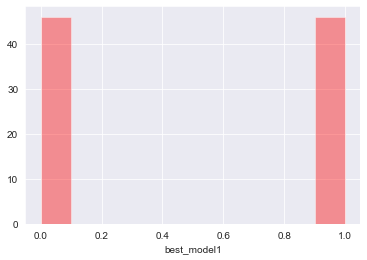

DV distribution:
 1    46
0    46
Name: best_model1, dtype: int64


In [6]:
subj_balance = balance_training_sample(subj_wide, DV)
sns.distplot(subj_balance[DV], kde=False, color='red', bins=10)
plt.show()

print('DV distribution:\n', subj_balance[DV].value_counts(normalize=False))

### Define Brain Region of Interest

Exclude some brain regions if necessary. 

Now, we obtain connectivity vector for NOI by combining `censor` with `subj_censored`

In [7]:
# define network of interest (NOI)
NOI = [
        "Uncertain",
        "Sensory/somatomotor Hand",
        "Sensory/somatomotor Mouth",
        "Cingulo-opercular Task Control",
        "Auditory",
        "Default mode",
        "Memory retrieval?",
        "Ventral attention",
        "Visual",
        "Fronto-parietal Task Control",
        "Salience",
        "Subcortical",
        "Cerebellar",
        "Dorsal attention"
]

In [8]:
censor = get_vector_df(power2011, NOI)        # filter some region connections
subj_censored = get_subj_df(subj_balance, censor)

features = list(subj_censored.columns)[2:]
print('The dimension of subj_censored is', subj_censored.shape, 'N = subj (upsampled), M = connections')

The dimension of subj_censored is (92, 34718) N = subj (upsampled), M = connections


---

### Logistic Regression Models

Here, we will use logistic regression with L1 penalty (LASSO) to identify the functional connectivity patterns that predict the ACT-R model outcome variable `best_model`: model1 / model2. To better fit in logistic model, this variable is changed to `best_model1` =  1/0


### Split training data and Testing set.

We will use cross-validation method (cv=10) OR leave-one-out(LOO) to find best L1 parameter `lambda`

In [10]:
### 90% split
train_data, test_data = train_test_split(subj_censored, test_size=0.1, random_state=1)  

print('The dimension of train_data', train_data.shape)
print('The dimension of test_data', test_data.shape)

The dimension of train_data (82, 34718)
The dimension of test_data (10, 34718)


#### Grid-Search HyperParameter (lambda) Tunning

Next, let's find the best `lambda_values` for Lasso Regression using grid search hyperparameter tunning

Visualize the  `lambda` and `coef_` path

In [10]:
# standar GS is too slow (400s +)
#grid_result = grid_search_lasso(train_data, features, DV, True)

Best Score: 0.99
Best Hyperparameters: {'C': 7.196856730011514}
Time usage: 236.361s


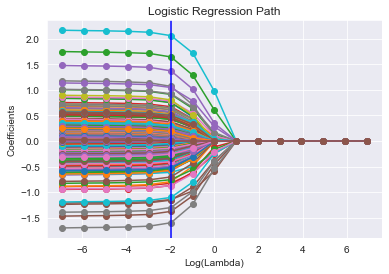

Time usage: 50.063s


In [11]:
# random GS (200s +)
grid_result1 = random_grid_search_lasso(subj_censored, features, DV, num_cv=20, plot_path=True)
_ = plot_regularization_score(grid_result1)

Best Score: 0.975
Best Hyperparameters: {'C': 19.306977288832496}
Time usage: 180.794s


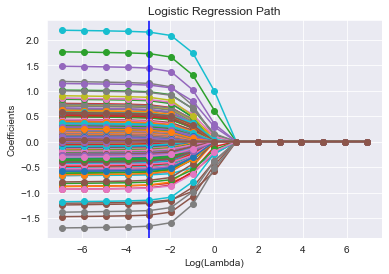

Time usage: 53.804s


In [25]:
# halving GS (100s +)
grid_result2 = halving_search_lasso(subj_censored, features, DV, plot_path=True)
_ = plot_regularization_score(grid_result2)

In [26]:
grid_result = grid_result1

Let's see how does the validation accuracy(score) changes as the L1(lambda) changes

### Re-Train Logistic Model

Next, we need to retrain the logistic model with best `lambda` 


In [29]:
best_C = grid_result.best_params_['C']
print('best lambda', 1.0/best_C)

best_lasso_model = LogisticRegression(penalty='l1', solver='saga', C=best_C, fit_intercept=False)
best_lasso_model.fit(subj_censored[features], subj_censored[DV])

best lambda 0.13894954943731389


LogisticRegression(C=7.196856730011514, fit_intercept=False, penalty='l1',
                   solver='saga')

#### Method1: Leave-One-Out

Applying the leave-one-out(LOO) method, we can evaluate the accuracy, ROC, and confusion matrix

In [30]:
# LOO is computationally expensive (400s +)
all_ytrue, all_yhat, all_yprob = loocv_logistic_retrain(subj_censored, features, DV, best_C)
loo_accuracy = accuracy_score(all_ytrue, all_yhat)

print('The Leave-One-Out Accuracy Score: {:.4f}'.format(loo_accuracy))

Time Usage (s) 357.2838
The Leave-One-Out Accuracy Score: 0.9891


#### Method2Cross-Validation (20)

If LOO method is tom computationally expensive, try cross-validation = 20

In [ ]:
# CV = 20 is more efficient (200s +)

all_ytrue, all_yhat, all_yprob, _ =cv_logistic_retrain(subj_censored, features, DV, best_C, 20)
loo_accuracy = accuracy_score(all_ytrue, all_yhat)

print('The Cross-Validation(20) Accuracy Score: {:.4f}'.format(loo_accuracy))

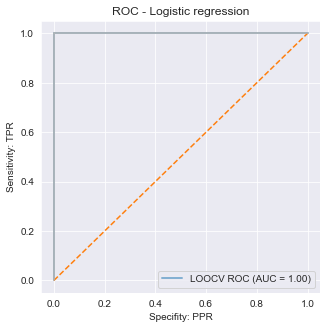

In [31]:
plot_roc_curve_loo(all_ytrue, all_yprob)

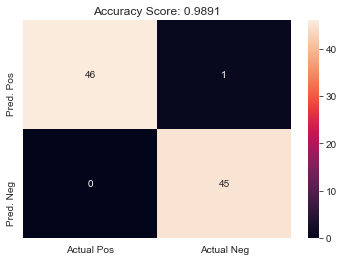

In [32]:
plot_confusion_matrix_loo(subj_censored[DV].values, all_yhat)

Let's look at strongest connections and the beta dataframe

In [33]:
betas = best_lasso_model.coef_[0]

min_connID = None
min_beta = betas[0]

max_connID = None
max_beta = betas[0]
for i in range(0, len(betas)):
    if betas[i] < min_beta:
        min_beta = betas[i]
        min_connID = features[i+1]
    if betas[i] > max_beta:
        max_beta = betas[i]
        max_connID = features[i+1]

print('min_beta', min_connID, min_beta)
print('max_beta',  max_connID, max_beta)

min_beta [134, 160] -0.49369579755239124
max_beta [102, 201] 0.5768091354462876


In [34]:
beta_df = pd.DataFrame({'connID':features, 'beta':best_lasso_model.coef_[0]})
total_bata, _ = beta_df.shape
survived_bata, _ = beta_df[beta_df['beta']!=0.0].shape

print('Total beta:', total_bata, '\nSurvive bata:', survived_bata, '\nPercentage', round(survived_bata/total_bata, 4))

Total beta: 34716 
Survive bata: 1527 
Percentage 0.044


### Prediction vs. Observed


Next, let's see the predict_proba vs. observation labels

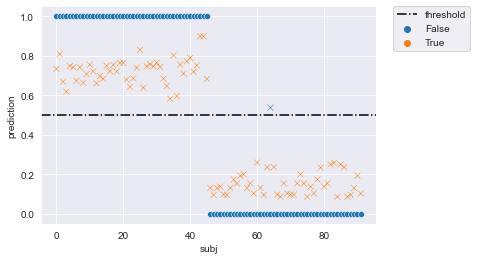

In [35]:
# plot the LOO output
#plot_prediction_loo(all_ytrue, all_yhat, all_yprob, 0.5)

# plot the CV output
plot_prediction_loo(all_ytrue, all_yhat, all_yprob, 0.5)

### Brain Mapping

Next, look at the beta value mapped on brain 

In [36]:
# matrix split to two half: censor_left and censor_right 
censor_left = censor.copy()
censor_left['beta'] = best_lasso_model.coef_[0]

The beta distribution

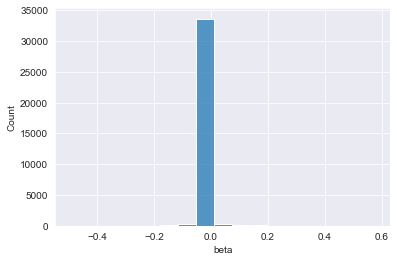

In [47]:
sns.histplot(data=censor_left, x='beta')
plt.show()

In [48]:
from nilearn import plotting
from nilearn import datasets

# make symmetric censor df
censor_right = censor_left[['connID', 'beta']].copy()
censor_right['connID'] = censor_right['connID'].apply(reverse_connID)
censor_LR = censor_left.append(censor_right, ignore_index=True)
censor_LR = censor_LR[['connID', 'beta']]

# merge to main roi df 
roi_df = get_ROI_df(power2011)
roi_df = roi_df.merge(censor_LR, how="left", on = ['connID'])
roi_df['beta'] = roi_df['beta'].replace(np.nan, 0.0)

# reformat beta matrix
adj_vector = roi_df['beta'].values
adj_beta = pd.DataFrame(vector2matrix(adj_vector), dtype='float')

coor_vector = np.array([(0,0,0) for i in range(264)])
power = datasets.fetch_coords_power_2011()
power_coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T

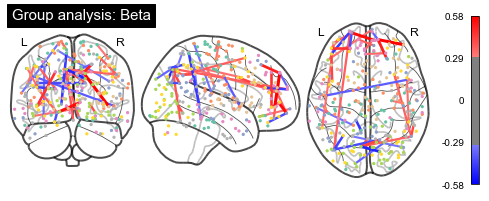

In [49]:
# grab center coordinates for atlas labels

# plot connectome with 80% edge strength in the connectivity

plotting.plot_connectome(adj_beta, power_coords,
                         edge_threshold='99.9%',
                         colorbar=True,
                         node_size=5,
                         alpha=.2,
                         title='Group analysis: Beta')
plt.show()


In [50]:
plotting.view_connectome(adj_beta, power_coords, 
                         edge_threshold='99.9%',
                         colorbar=True,
                         node_size=1,
                         title='Group analysis: Beta').open_in_browser()